# ARIM情報活用講座：基礎編　RDKitの実践的な使い方

## 本編の目標
先行研究の論文では、サプリメントデータなどにSMILES構造が含まれたcsvファイルが存在することがあります。このようなファイルに記載されたSMILESを取得する手順を、具体的な例を用いて学びます。

## データセット
本編で扱う "delaney-processed.csv" は、1128種の化合物の水溶解度に関するデータセットです。このデータセットは、J.S. Delaneyが2004年に発表した論文『ESOL: Estimating Aqueous Solubility Directly from Molecular Structure』[1] に基づいています。このデータセットは、ケモインフォマテックス分野で幅広く知られており、水溶解度の予測に関するものです。

[1] John S. Delaney, "ESOL: Estimating Aqueous Solubility Directly from Molecular Structure", *J. Chem. Inf. Comput. Sci.*, **44**, 1000–1005 (2004) (DOI: 10.1021/ci034243x)

"delaney-processed.csv" には、分子の化学式、SMILES表記、そして水溶解度としてのオクタノール水分配係数が含まれています。これらの特性は、薬物探索や環境影響評価などの目的で広く活用されています。


1. Compound ID	：化合物ID
1. ESOL predicted log solubility in mols per litre　：log水溶解度（オクタノール水分配係数）の予測値	
1. Minimum Degree：　最小次数	
1. Molecular Weight：分子量	
1. Number of H-Bond Donors	：　水素結合に関与するDonor数
1. Number of Rings	：芳香環の数	
1. Number of Rotatable Bonds　：　回転可能結合数	
1. Polar Surface Area　：　極性表面積	
1. measured log solubility in mols per litre：log水溶解度の実測値	
1. smiles：SMILES表記

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install rdkit-pypi
!git clone https://github.com/ARIM-Academy/Advanced_Tutorial_2.git
%cd Advanced_Tutorial_2

## 1.分子構造データの読み込み

### 汎用ライブラリのインポート
第一回で学んだRDKitに関するモジュールをimportします。

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

### ファイルの読み込み

この場面では、data/daataset/delaney-solubilityフォルダ内のdelaney-processed.csvファイルをpandasの`read_csv`関数を使用してデータフレーム（DataFrame）として読み込み、変数dfに格納します。dfは1,128の化合物に関する10の特徴量から成るデータ行列であることが確認できます。

In [5]:
file = './data/dataset/delaney-processed.csv'
df = pd.read_csv(file)
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


### 【Tips】高度な可視化
特に注目すべき特徴量は、予測されたlog水溶解度（ESOL predicted log solubility in mols per litre）と実験値（measured log solubility in mols per litre）の間の相関です。この相関について、相関図とヒストグラムの2つの異なる視覚化方法を用いて出力して確認をしてみましょう。  

下記の可視化図はNorwegian University of Science and TechnologyのAnders Lervik氏のブログにある https://www.andersle.no/posts/2022/esol/esol.html　を参照しています。

### 相関図

In [6]:
from sklearn.metrics import r2_score, mean_absolute_error

In [7]:
def add_scatterplot(ax, measured, predicted, model_name=None):
    """Add a measured vs. predicted scatter plot."""
    
    rsquared = r2_score(measured, predicted)
    mae = mean_absolute_error(measured, predicted)
    
    label = f"R²: {rsquared:.2f}\nMAE = {mae:.2f}"
    
    if model_name:
        label = f"{model_name}\n{label}"
    
    ax.scatter(measured,predicted,label=label,alpha=0.8)

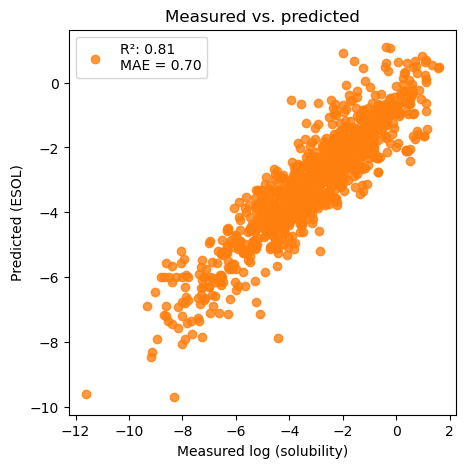

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter([], [])  # cycle colors

measured = df['measured log solubility in mols per litre']
esol = df['ESOL predicted log solubility in mols per litre']

add_scatterplot(ax, measured, esol)

ax.set(
    xlabel="Measured log (solubility)",
    ylabel="Predicted (ESOL)",
    title="Measured vs. predicted",
)

ax.legend()
plt.show()

### ヒストグラム

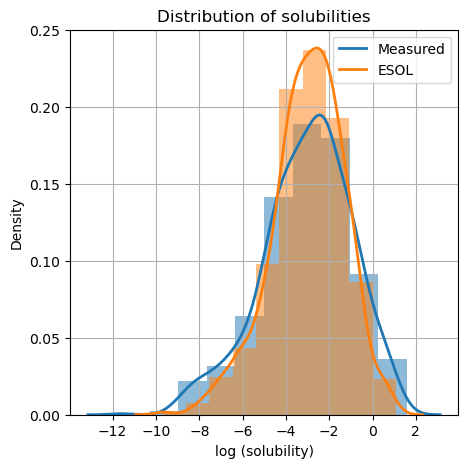

In [12]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(5, 5))

# 実験値と予測値のヒストグラム
_, _, hist1 = ax.hist(df['measured log solubility in mols per litre'], density=True, alpha=0.5)
_, _, hist2 = ax.hist(df['ESOL predicted log solubility in mols per litre'], density=True, alpha=0.5)

# 実験値と予測値のkdeプロット
sns.kdeplot(
    data=df,
    x=df['measured log solubility in mols per litre'],
    ax=ax,
    label="Measured",
    color=hist1.patches[0].get_facecolor(),
    lw=2,
)

sns.kdeplot(
    data=df,
    x=df['ESOL predicted log solubility in mols per litre'],
    ax=ax,
    label="ESOL",
    color=hist2.patches[0].get_facecolor(),
    lw=2,
)

ax.legend()
ax.set(xlabel="log (solubility)", title="Distribution of solubilities")

ax.grid()
plt.show()

## 2.RDKitによる化合物の可視化
10列目の「smile」にある文字列は分子構造をテキストベースで表現するSMILESです。前回で学んだRDKitライブラリを使って機械可読させることができます。ここでは一列目のAmigdalinを`MolFromSmiles`メソッドから可視化してみましょう。

dfの`'smiles'`列を確認します。

In [7]:
df['smiles']

0       OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1                                  Cc1occc1C(=O)Nc2ccccc2
2                                    CC(C)=CCCC(C)=CC(=O)
3                      c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4                                                 c1ccsc1
                              ...                        
1123                                     FC(F)(F)C(Cl)Br 
1124                            CNC(=O)ON=C(SC)C(=O)N(C)C
1125                                    CCSCCSP(=S)(OC)OC
1126                                              CCC(C)C
1127                COP(=O)(OC)OC(=CCl)c1cc(Cl)c(Cl)cc1Cl
Name: smiles, Length: 1128, dtype: object

一列目のAmigdalinのSMILESは、次のように0行目のスライスを指定して読み出すことができます。

In [8]:
df['smiles'][0]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

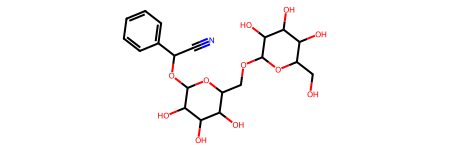

In [9]:
Amigdalin =  Chem.MolFromSmiles(df['smiles'][0])
Amigdalin

### 複数の分子を表示
こちらも第一回で学んだ`MolsToGridImage`メソッドを使った表示例です。molsPerRow=3として横に３つの分子を配置します。

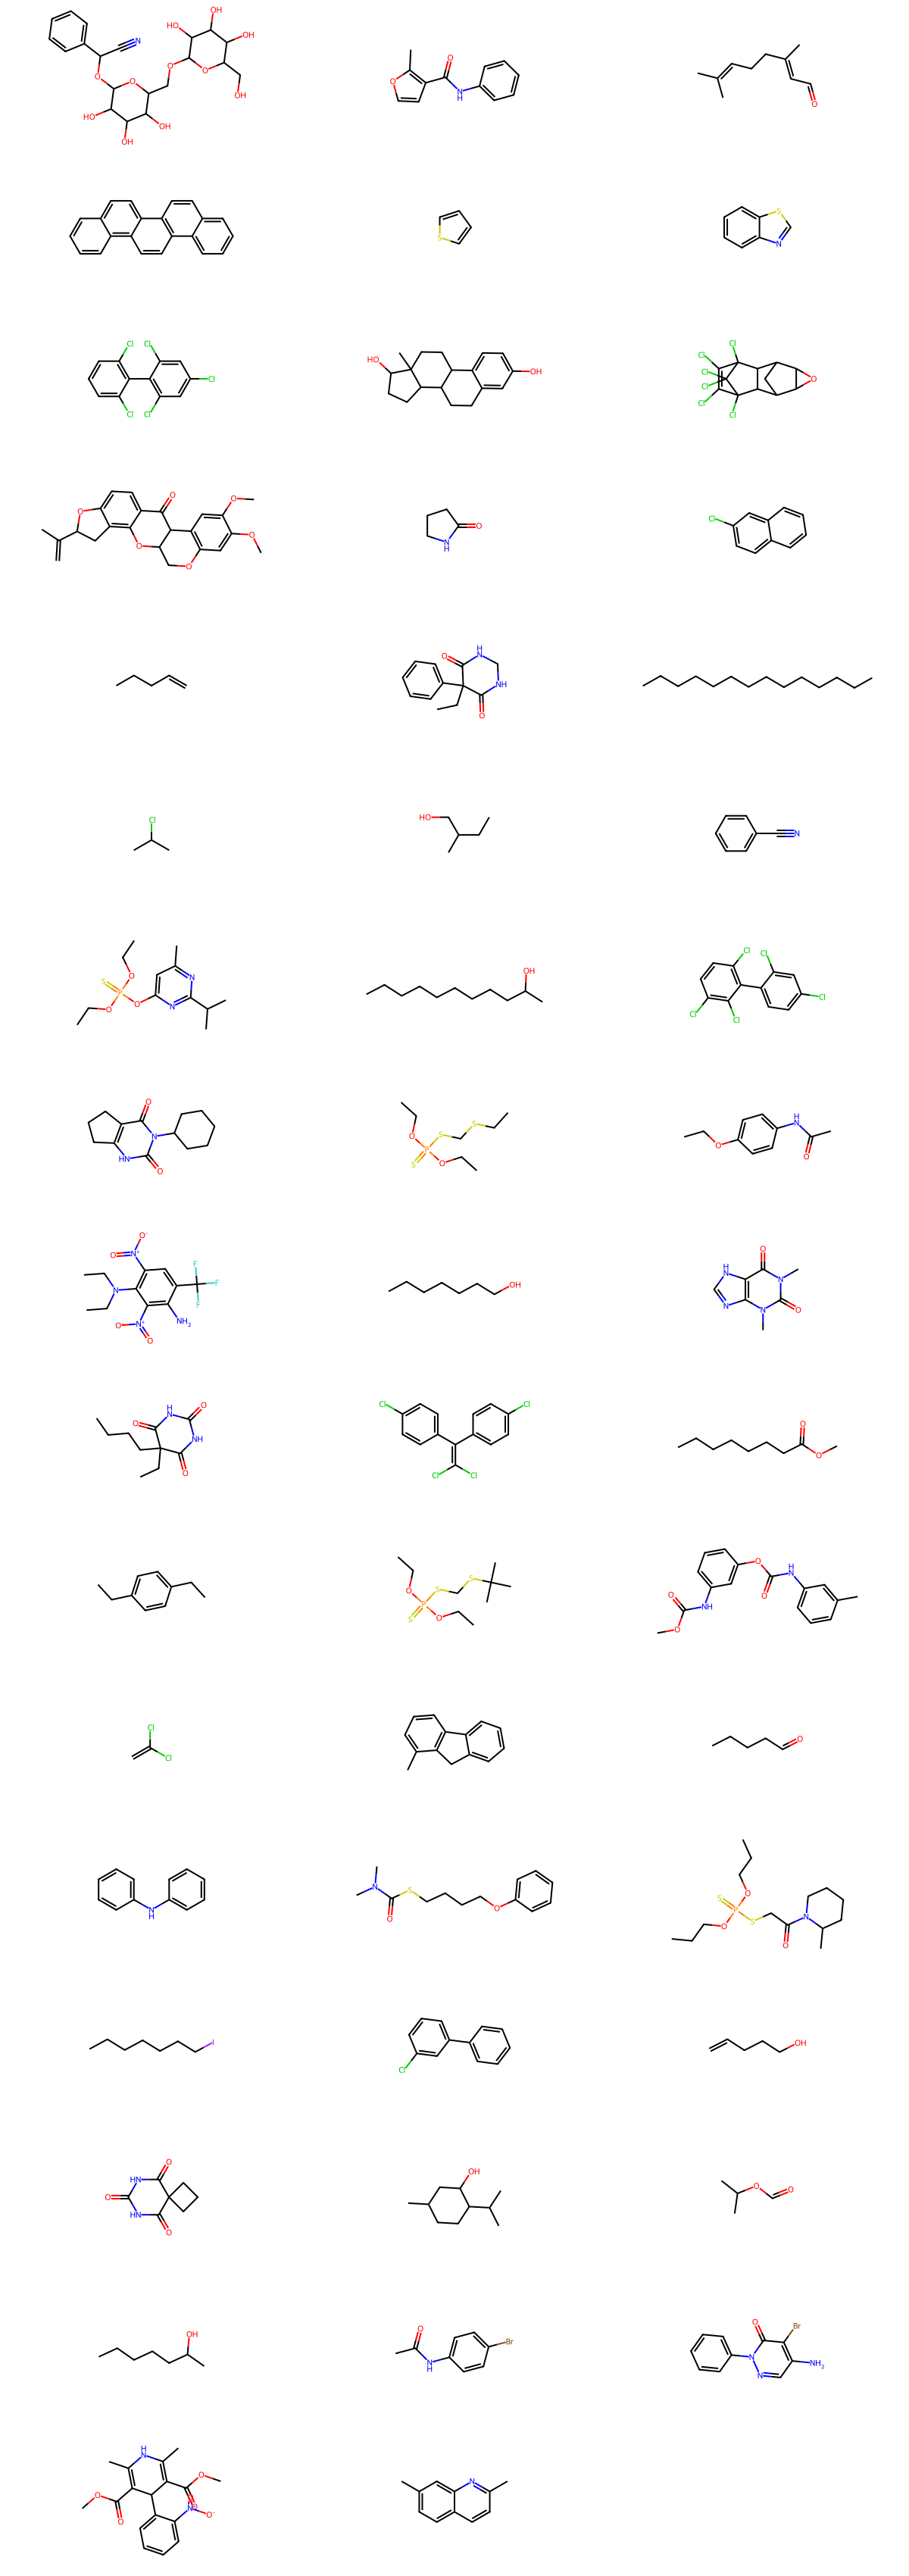

In [11]:
mols = [Chem.MolFromSmiles(smi) for smi in df['smiles']]

Draw.MolsToGridImage(mols, 
                     molsPerRow=3, 
                     subImgSize=(400, 200)
                    )

## 3.複数化合物のmolオブジェクト化
1,128の化合物のSMILES構造からMolオブジェクトを生成するにはどうすればよいのでしょうか。一つ一つを読み出して`MolFromSmiles`メソッドで変換をかける方法は大変です。  

ところが、`apply`メソッドを活用することで、次の一行で処理を実行でき、とても簡単に進められます。  

具体的には、mol['smiles']列に`apply`メソッドの引数に`MolFromSmiles`メソッドを適用し、新たに['mol']列をデータフレームに追加します。  
['mol']列がデータフレームの最終列に正常に追加されたことを確認してみましょう。

In [10]:
df['mol']=df['smiles'].apply(Chem.MolFromSmiles)
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x00000132AEA...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x00000132AEA...
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x00000132AEA...
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x00000132AEA...
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x00000132AEA...
...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,<rdkit.Chem.rdchem.Mol object at 0x00000132AEA...
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000132AEA...
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x00000132AEA...
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000132AEA...


【解説】 **`apply()`** メソッドについて    
`apply`メソッドはPandasライブラリに含まれており、DataFrameオブジェクトに対して特定の関数を適用するために使用されます。`apply`メソッドは、各行または列に対して関数を適用し、その結果を新しいDataFrameまたはSeriesとして返します。

以下に、`apply`メソッドの基本的な使についてつか説明します。

1. 列ごとにメソッドを適用する場合:

```python
import pandas as pd

# サンプルのDataFrameを作成
data = {'A': [1, 2, 3], 'B': [4, 5, 6]}
df = pd.DataFrame(data)

# 列ごとにメソッドを適用して新しい列を作成
def square(x):
    return x**2

df['A_squared'] = df['A'].apply(square)
```

上記のコードでは、`square`関数を使って'A'列の各要素を2乗し、新しい'A_squared'列にその結果を保存します。

2. 行ごとにメソッドを適用する場合:

```python
import pandas as pd

# サンプルのDataFrameを作成
data = {'A': [1, 2, 3], 'B': [4, 5, 6]}
df = pd.DataFrame(data)

# 行ごとに関数を適用して新しい列を作成
def sum_of_row(row):
    return row['A'] + row['B']

df['Sum'] = df.apply(sum_of_row, axis=1)
```

上記のコードでは、`sum_of_row`関数を使って各行の'A'列と'B'列の要素を合計し、新しい'Sum'列にその結果ます。データの変換や計算を行う際に、`apply`メソッドは非常に便利なツールです。

molオブジェクトはデータフレーム形式のルールに従った行番号を指定して次のようにして分子構造を表示させることができます。

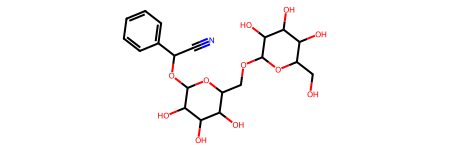

In [12]:
# 最初のCompound ID =Amigdalin のアミグダリンについて化合物を表示
df['mol'][0]

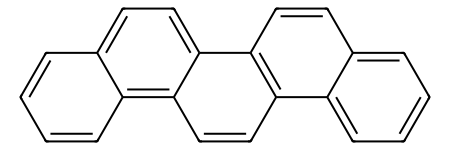

In [13]:
# 4つ目のピセンについて化合物を表示
df['mol'][3]

## 4.PandasToolsモジュールを使ったサンプルの確認


`PandasTools`モジュールは、RDKitのの機能一あPandasデータフレームとRDKitの分子オブジェクトを相互に変換したり、データフレーム内の分子データを簡単に処理したりすることができます。以下に、`PandasTools`モジュールの主な機能といくつかの使用例を示します。

1. **分子オブジェクトとデータフレームの変換**:

   `PandasTools`を使用して、RDKitの分子オブジェクトとPandasデータフレームの間でデータを簡単に変換できます。例えば、化合物のSMILES表現からPandasデータフレームに変換することができます。

   ```python
   from rdkit import Chem
   from rdkit.Chem import PandasTools

   smiles = ['CCO', 'CCN', 'C=O']
   mols = [Chem.MolFromSmiles(smi) for smi in smiles]

   df = PandasTools.LoadSDF('compounds.sdf')  # SDFファイルから読み込む
   df['Molecule'] = mols  # 分子オブジェクトをデータフレームに追加
   ```

2. **分子の記述子計算（第三回）**:

   データフレーム内の分子に対してさまざまな分子記述子（例: 質量、ロタボンド数、水素結合ドナー数など）を計算できます。

   ```python
   from rdkit.Chem import Descriptors

   df['MolecularWeight'] = df['Molecule'].apply(Descriptors.MolWt)
   ```

3. **分子間の類似性評価（第四回）**:

   データフレーム内の分子の類似性を計算することができます。類似性は、指定した類似性スコア（例: Tanimoto係数）を計算する関数を使用して行われます。

   ```python
   from rdkit.Chem import AllChem

   df['Similarity'] = df['Molecule'].apply(lambda x: AllChem.TanimotoSimilarity(x, reference_molecule))
   ```

4. **フィルタリング**:

   データフレーム内の分子を特定の条件に基づいてフィルタリングできます。

   ```python
   filteredint(df)
    ```

この例では、分子のSMILES表現を含むPandasデータフレームに、RDKitのMolオブジェクトを表す新しい列を追加しています。データフレームにMolオブジェクトの列が追加され、RDKitの機能を利用して分子の操作や特徴量の計算が行えるようになります。

In [14]:
from rdkit.Chem import PandasTools

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol,ROMol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,,
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,,
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),,
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,,
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,,
...,...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,,
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,,
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,,
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,,

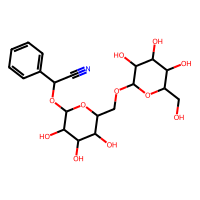
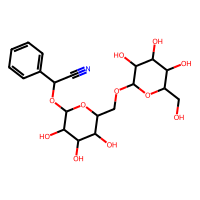
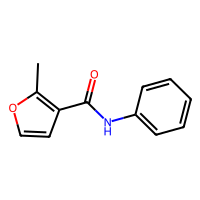
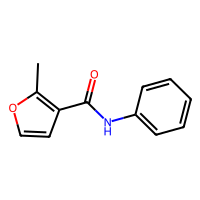
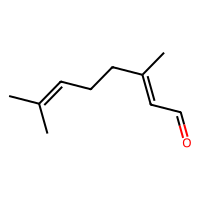
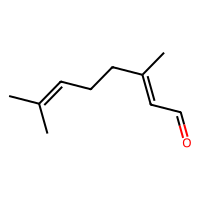
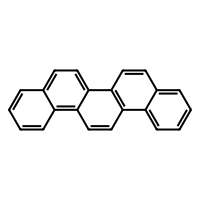
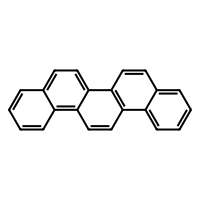
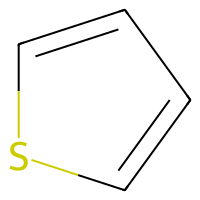
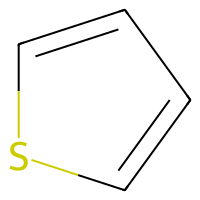
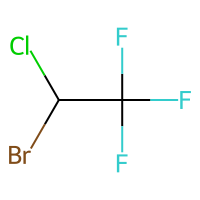
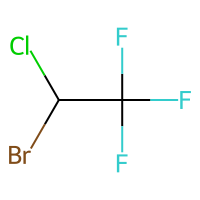
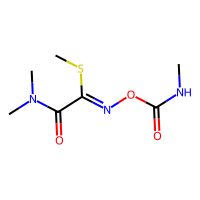
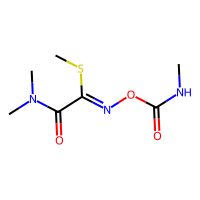
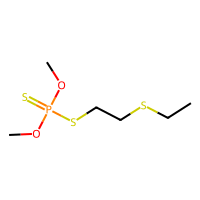
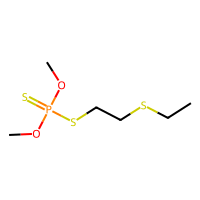
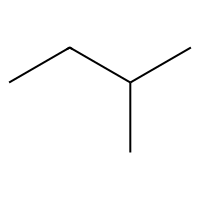
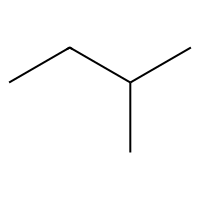
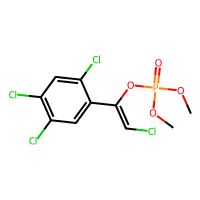
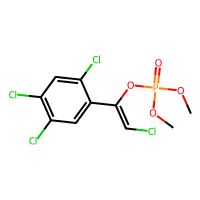

In [15]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')
df

【解説】`PandasTool`モジュールの主なメソッド  

1. `AddMoleculeColumnToFrame`: 分子のSMILES表現を含むPandasデータフレームに、RDKitのMolオブジェクトを表す新しい列を追加します。

2. `RemoveMoleculeColumnFromFrame`: RDKitのMolオブジェクトを表す列をPandasデータフレームから削除します。

3. `ConvertToMoleculeColumn`: 分子のSMILES列をRDKitのMolオブジェクトを表す列に変換します。

4. `PandasTools.RenderImagesInAllDataFrames`: 分子の画像をPandasデータフレームに表示します。

以下は、`PandasTools`を使った例です：

```python
from rdkit import Chem
from rdkit.Chem import PandasTools
import pandas as pd

# データフレームを作成
data = {'SMILES': ['CCO', 'CN=C=O', 'CCN(CC)C(=O)OC1=CC=CC=C1C(=O)O']}
df = pd.DataFrame(data)

# SMILES列からMolオブジェクトの列を追加
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='SMILES')

# データフレームを表示
print(df)
```

この例では、分子のSMILES表現を含むPandasデータフレームに、RDKitのMolオブジェクトを表す新しい列を追加しています。データフレームにMolオブジェクトの列が追加され、RDKitの機能を利用して分子の操作や特徴量の計算が行えるようになります。

### PandasToolsによる分子構造と変数の表示例

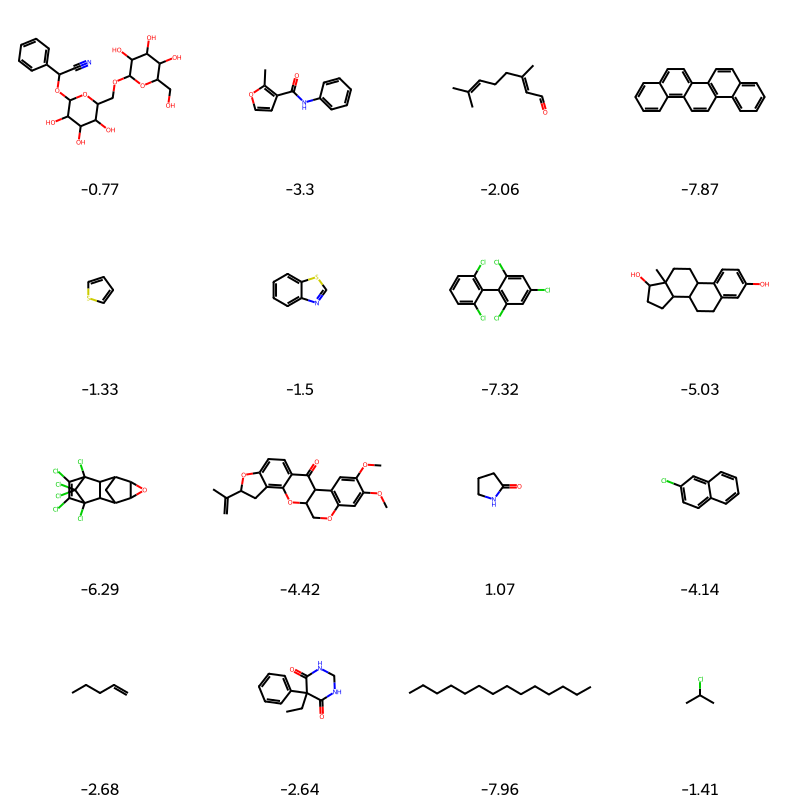

In [16]:
PandasTools.FrameToGridImage(df.head(16), 
                             legendsCol="measured log solubility in mols per litre", 
                             molsPerRow=4)

【解説】 **`FrameToGridImage`** メソッド  
RDKitを使用して作成した分子データのグリッド画像を生成するための関数です。このメソッドは、分子データを含むPandasデータフレームを受け取り、その分子を格子状に配置して画像として出力します。これは、化学データを視覚化するためによく使用されます。

以下に、`FrameToGridImage`メソッドの基本的な使い方と例を示します。

```python
from rdkit import Chem
from rdkit.Chem import PandasTools
from IPython.display import Image

# サンプルのデータフレームを作成
data = {'ID': [1, 2, 3],
        'SMILES': ['CCO', 'CCN', 'C=O']}
df = pd.DataFrame(data)

# SMILESからRDKitの分子オブジェクトを作成し、データフレームに追加
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='SMILES')

# 分子データフレームをグリッド画像に変換
img = PandasTools.FrameToGridImage(df, legendsCol='ID', molsPerRow=3)

# 画像を表示
Image(img)
```

このコードでは、まず`PandasTools.AddMoleculeColumnToFrame`を使用して、'SMILES'列からRDKitの分子オブジェクトを作成し、'Molecule'列に追加しています。次に、`PandasTools.FrameToGridImage`メソッドを使用して、分子データフレームをグリッド画像に変換します。`legendsCol`引数には分子のラベルとして使用する列（ここでは'ID'列）を指定し、`molsPerRow`引数には1行に表示する分子の数を指定しています。

生成されたグリッド画像は、Jupyter Notebookなどの環境で直接表示することができます。これにより、化学構造を視覚的に比較したりDKitを使用した化学データの解析と可視化を支援します。